<a href="https://colab.research.google.com/github/DerekGloudemans/Classification-ISIC-2018/blob/master/ResNet50_Multiclass_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [0]:
%%capture 
!unzip "/content/drive/My Drive/Colab Notebooks/ISIC-2018-classifiers/ISIC2018_Task3_Training_Input.zip"
!unzip "/content/drive/My Drive/Colab Notebooks/ISIC-2018-classifiers/ISIC2018_Task3_Training_GroundTruth.zip"

In [2]:
#%%capture 
!pip install -q --upgrade ipython==5.5.0
!pip install -q --upgrade ipykernel==4.6.0
!pip3 install torchvision
!pip3 install opencv-python

#!pip uninstall torch -y
#!pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cu100/torch_nightly.html

import ipywidgets
import traitlets

#!pip3 install filterpy
#!pip3 install opencv-contrib-python

In [0]:
# imports

# this seems to be a popular thing to do so I've done it here
#from __future__ import print_function, division


# torch and specific torch packages for convenience
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils import data
from torch import multiprocessing
from google.colab.patches import cv2_imshow

# for convenient data loading, image representation and dataset management
from torchvision import models, transforms
from PIL import Image, ImageFile, ImageStat
ImageFile.LOAD_TRUNCATED_IMAGES = True
from scipy.ndimage import affine_transform
import cv2

# always good to have
import time
import os
import numpy as np    
import _pickle as pickle
import random
import copy
import matplotlib.pyplot as plt
import math



In [0]:
def get_dataset_mean(directory):
  """
  Returns mean and standard deviation for image dataset
  """
  im_list = [os.path.join(directory,item) for item in os.listdir(directory)]
  ims = []
  for item in im_list:
    if item.endswith(".jpg"):
      ims.append(item)

  running_mean = np.zeros(3)
  running_std = np.zeros(3)
  for item in ims:
    # load image file
    im = Image.open(item)
    stats = ImageStat.Stat(im)
    mean = np.array([stats.mean[0],stats.mean[1],stats.mean[2]])
    stddev = np.array([stats.stddev[0],stats.stddev[1],stats.stddev[2]])
    running_mean += mean
    running_std += stddev

  mean = running_mean / len(ims)
  stddev = running_std   / len(ims)

  return mean, stddev

In [0]:
# This takes a few minutes so only run it once
if False:
  get_dataset_mean("/content/ISIC2018_Task3_Training_Input")

# output is:
# mean - [194.69792021, 139.26262747, 145.48524136]
# stddev - [22.85509458, 30.16841156, 33.90319049]

In [0]:
class Im_Dataset(data.Dataset):
    """
    Defines a custom dataset for loading images from the ISIC 2018 lesion 
    classification challenge. Images are divided into a training and validation
    partition with equal class distribution in each, and numerous transforms 
    are applied if in training mode
    """
    
    def __init__(self, mode = "train",class_balance = False):
        """ 
        mode = train or validation
        """
        self.mode = mode
        self.class_balance = class_balance
        self.im_mean = np.array([194.69792021/255, 139.26262747/255, 145.48524136/255])
        self.im_stddev = np.array([22.85509458/255, 30.16841156/255, 33.90319049/255])

        self.label_names = []
        self.labels = {}
        self.im_dir = "/content/ISIC2018_Task3_Training_Input"
        self.im_list = []
        self.train_indices = []
        self.val_indices = []
        self.all_train_indices = []
        self.all_val_indices = []

        ## load files in image directory
        im_list = [item for item in os.listdir(self.im_dir)]
        #get images only
        for item in im_list:
          if item.endswith(".jpg"):
            self.im_list.append(item.split(".")[0])

        self.im_list.sort()
        
        ## load labels
        self.label_dir = "/content/ISIC2018_Task3_Training_GroundTruth"
        
        # read label csv file
        f = open(os.path.join(self.label_dir,"ISIC2018_Task3_Training_GroundTruth.csv"),'r')
        label_text = f.readlines()
        
        # parse each line
        self.label_names = label_text[0].split(',')[1:]
        for item in label_text[1:]:
            splits = item.split(",")
            name = splits[0]
            splits = splits[1:]
            data = []
            for val in splits:
                data.append(np.round(float(val.rstrip())))
            arr = np.array(data)

            # flatten 7-d binary label into 1-d integer label
            #arr = arr.nonzero()[0]

            # convert to torch
            label = torch.from_numpy(arr).float()
            self.labels[name] = label

        # split data by class
        self.class_indices = []
        for i in range(0,7):
          indices = []
          for j, item in enumerate(self.im_list):
            if self.labels[item][i] == 1:
              indices.append(j)
          self.class_indices.append(indices)

        for indices in self.class_indices:
            self.all_train_indices.append(indices[:int(len(indices)*0.85)])
            self.all_val_indices.append(indices[int(len(indices)*0.85):])
        
        # flatten val_indices
        for cls in self.all_val_indices:
            for idx in cls:
                self.val_indices.append(idx)

        if class_balance: # balances positive and negative examples in training data
            self.shuffle_balance()



        # define transforms
        self.transforms_train = transforms.Compose([
                transforms.ColorJitter(brightness = 0.2,contrast = 0.2,saturation = 0.1),
                transforms.RandomAffine(15,scale = (1.1,1.2),shear = 10,resample = Image.BILINEAR,fillcolor = (194,139,145)),
                transforms.RandomVerticalFlip(),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(self.im_mean,self.im_stddev,inplace = True)                             
        ])

        self.transforms_val = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(self.im_mean,self.im_stddev,inplace = True)                                                
        ])

    def shuffle_balance(self):
      """
      Returns a list of positive indices and negative indices for training mode
      such that the number of positives and negatives is the same
      """

      # get min class size
      lengths = []
      for cls in self.all_train_indices:
          lengths.append(len(cls))
      min_length = min(lengths)  

      # get random subset of each class with min_length of each class
      self.train_indices = []
      for cls in self.all_train_indices:
          random.shuffle(cls)
          for idx in cls[:min_length]:
              self.train_indices.append(idx)





    def __getitem__(self,idx):
        """
        Note: index gives the index of either self.train_indices or 
        self.val_indices. The value at that index is itself an index to 
        self.im_list, which contains a string name of a file. This is done to
        keep training and validation sets separate but from the same underlying 
        data for correct class distribution
        """

        # get image name
        if self.mode == "train":
          im_idx = self.train_indices[idx]
        else:
          im_idx = self.val_indices[idx]
        
        im_name = self.im_list[im_idx]

        y = self.labels[im_name]

        # load image file
        im = Image.open(os.path.join(self.im_dir,im_name +'.jpg'))
      
        
        # apply transforms to image
        if self.mode == "train":
          x = self.transforms_train(im)
        else:
          x = self.transforms_val(im)

        return x, y

    def __len__(self):
      if self.mode == "train":
        return len(self.train_indices)
      else:
        return len(self.val_indices)


    def show(self,idx):
        im,label = self[idx]
        if self.mode == "train":
          label = "Image: {} || ".format(self.im_list[self.train_indices[idx]]) \
           + "Label: " + self.label_names[np.where(label == 1)[0][0]]
        else:
          label = "Image: {} || ".format(self.im_list[self.val_indices[idx]]) \
           + "Label: " + self.label_names[np.where(label == 1)[0][0]]
        # shift axes and convert RGB to GBR for plotting
        im = im.data.numpy().transpose(1, 2, 0)
         

        # unnormalize
        im = self.im_stddev * im + self.im_mean
        im = np.clip(im, 0, 1)
        im = im[:, :, ::-1]
        im = im.copy()
        cv2.putText(im,label,(20,40),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        #plot label
        im = im.copy()*255
        cv2_imshow(im)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        

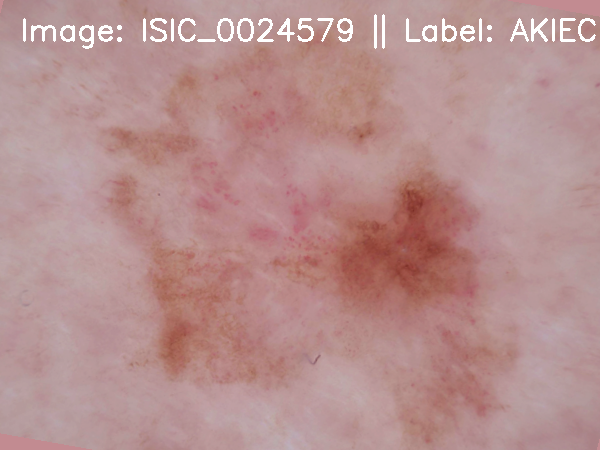

In [6]:
im_data = Im_Dataset(class_balance = True, mode = "train")

# sample image
idx = random.randint(0,len(im_data)-1)
im_data.show(idx)

In [0]:
# define a super simple ResNet model to see how it does
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
         
        #self.features = models.resnet18(pretrained = True)
        self.features = models.resnet50(pretrained = True)
        self.features.fc = nn.Linear(2048,128)
        
        self.batchnorm = nn.BatchNorm1d(128)
        self.drop = nn.Dropout()
        self.fc1 = nn.Linear(128,32)
        self.fc2 = nn.Linear(32,7)
        

    def forward(self, x):
        x = self.features(x)
        x = self.batchnorm(x)

        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = torch.sigmoid(self.fc2(x))
        #x = torch.softmax(x,dim = 0)
                
        return x



In [26]:
def train_model(model, optimizer, scheduler,loss_function,
                    datasets,device, num_epochs=5, start_epoch = 0,
                    all_losses = None,all_accs = None):
        """
        Alternates between a training step and a validation step at each epoch. 
        Validation results are reported but don't impact model weights
        """
        # for storing all metrics
        if all_losses == None:
          all_losses = {
                  'train':[],
                  'val':[]
          }
          all_accs = {
                  "train":[],
                  "val":[]
                  }
        avg_acc = 0
        
        # for early stopping
        best_acc  = 0
        epochs_since_improvement = 0
        
        # create testloader for val_dataset (trainloader is made each epoch)
        params = {'batch_size': 12,
              'shuffle': True,
              'num_workers': 0,
              'drop_last' : True
              }
        testloader = data.DataLoader(datasets["val"],**params)

        for epoch in range(start_epoch,num_epochs):
            # reshuffle dataset to get new set of positives or negatives
            if datasets["train"].class_balance:
                datasets["train"].shuffle_balance()
            trainloader = data.DataLoader(datasets["train"],**params)
            dataloaders = {"train":trainloader,"val":testloader}
            
            print("")

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                    if epoch > 0:
                      scheduler.step(avg_acc)
                else:
                    model.eval()   # Set model to evaluate mode
                #print("Epoch {}: learning rate {}".format(epoch,optimizer.param_groups[lr]))

                # Iterate over data.
                count = 0
                total_loss = 0
                total_acc = 0
                for inputs, targets in dataloaders[phase]:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    
                    # zero the parameter gradients
                    optimizer.zero_grad()
    
                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        
                        # shift targets to 1 0 positive negative labels
                        #targets = 1- torch.ceil(torch.abs((targets.float()-positive_class)/7))
                        loss = loss_function(outputs,targets)
                        acc = eval_accuracy(outputs,targets)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
        
                    # verbose update
                    count += 1
                    total_acc += acc
                    total_loss += loss.item()
                    if count % 20 == 0:
                      print("{} epoch {} batch {} -- Loss: {:03f} -- Accuracy {:02f}".format(phase,epoch,count,loss.item(),acc))
                
                avg_acc = total_acc/count
                avg_loss = total_loss/count
                if epoch % 1 == 0:
                  print("Epoch {} avg {} loss: {:05f}  acc: {}".format(epoch, phase,avg_loss,avg_acc))
                  all_losses[phase].append(total_loss)
                  all_accs[phase].append(avg_acc)

                  # save a checkpoint
                  PATH = "balanced_epoch{}.pt".format(epoch)
                  torch.save({
                      'epoch': epoch,
                      'model_state_dict': model.state_dict(),
                      'optimizer_state_dict': optimizer.state_dict(),
                      "losses":all_losses,
                      "accs":all_accs
                      }, PATH)
                  
                torch.cuda.empty_cache()
                
            # stop training when there is no further improvement
            if avg_acc > best_acc:
                epochs_since_improvement = 0
                best_acc = avg_acc
            else:
                epochs_since_improvement +=1
            print("{} epochs since last improvement.".format(epochs_since_improvement))
            #if epochs_since_improvement >= 5:
            #    break
                
        return model , all_losses,all_accs

def eval_accuracy(pred,actual):
  """
  Returns the accuracy of the predictions (hard instead of softmax loss)
  """
  pred = torch.argmax(pred,dim = 1)
  actual = torch.argmax(actual,dim = 1)
  diff = torch.where((actual - pred) != 0)[0]
  accuracy = 1 - len(diff)/len(actual)
  return accuracy

def load_model(checkpoint_file,model,optimizer):
    """
    Reloads a checkpoint, loading the model and optimizer state_dicts and 
    setting the start epoch
    """
    checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    all_losses = checkpoint['losses']
    all_accs = checkpoint['accs']

    return model,optimizer,epoch,all_losses,all_accs

SyntaxError: ignored

In [0]:
torch.cuda.empty_cache()
del model
del train_dataset
del val_dataset

In [25]:
if __name__ == "__main__":
    try:
        torch.multiprocessing.set_start_method('spawn')    
    except:
        pass

    # CUDA for PyTorch
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")
    if torch.cuda.device_count() > 1:
        print("Using multiple GPUs")
        MULTI = True
    else:
        MULTI = False
    torch.cuda.empty_cache()   
    

    #%% Create Model
    try:
        model
    except:
        model = Net()
        if MULTI:
            model = nn.DataParallel(model)
        model = model.to(device)
        print("Loaded model.")


    #%% Create datasets
    try:
        train_dataset
    except:
        train_dataset  = Im_Dataset(mode = "train", class_balance = True)
        val_dataset = Im_Dataset(mode = "val")
        datasets = {"train":train_dataset, "val": val_dataset}
        print("Loaded datasets.")
    
    start_epoch = -1
    num_epochs = 200

    loss = nn.BCELoss()

    optimizer = optim.SGD(model.parameters(), lr= 0.03,momentum = 0.1)    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.3, mode = "max", patience = 5,verbose=True)

    checkpoint = "balanced_epoch7.pt"
    
    if checkpoint:
      model,optimizer,start_epoch,all_losses,all_accs = load_model(checkpoint,model, optimizer)
      print("Reloaded checkpoint {}.".format(checkpoint))
    if True:    
    # train model
        print("Beginning training on {}.".format(device))
        model,all_losses,all_accs = train_model(model,  optimizer, scheduler,
                            loss, datasets,device,
                            num_epochs, start_epoch+1,all_losses= None,all_accs= None)

    torch.cuda.empty_cache()  

Reloaded checkpoint balanced_epoch7.pt.
Beginning training on cuda:0.

train epoch 8 batch 20 -- Loss: 0.226760 -- Accuracy 0.583333
train epoch 8 batch 40 -- Loss: 0.169302 -- Accuracy 0.666667
Epoch 8 avg train loss: 0.155387  acc: 0.7872023809523812
val epoch 8 batch 20 -- Loss: 0.445053 -- Accuracy 0.250000
val epoch 8 batch 40 -- Loss: 0.396386 -- Accuracy 0.333333
val epoch 8 batch 60 -- Loss: 0.349018 -- Accuracy 0.250000
val epoch 8 batch 80 -- Loss: 0.335578 -- Accuracy 0.500000
val epoch 8 batch 100 -- Loss: 0.467285 -- Accuracy 0.166667
val epoch 8 batch 120 -- Loss: 0.454877 -- Accuracy 0.166667
Epoch 8 avg val loss: 0.401508  acc: 0.31133333333333335
0 epochs since last improvement.

train epoch 9 batch 20 -- Loss: 0.105025 -- Accuracy 0.916667
train epoch 9 batch 40 -- Loss: 0.124880 -- Accuracy 0.833333
Epoch 9 avg train loss: 0.148111  acc: 0.7991071428571429
val epoch 9 batch 20 -- Loss: 0.461030 -- Accuracy 0.166667
val epoch 9 batch 40 -- Loss: 0.467343 -- Accuracy 0

KeyboardInterrupt: ignored

In [27]:
model(next(iter(trainloader))[0].to(device))

NameError: ignored

In [0]:
def evaluate(model,dataset,mode = "normal"):
  """
  Gets prediction metrics for whole network using model to predict
  mode - if "multi" - performs flips and one center crop of image and predicts using all
  """
  
  eval_array = torch.zeros([7,7])
  for i in range(len(dataset)):
    image,label = dataset[i]
    image = image.to(device).unsqueeze(0) 

    if mode == "4-flip":
      flip1 = torch.flip(image,[2])
      flip2 = torch.flip(image,[3])
      flip3 = torch.flip(image,[2,3])
      image = torch.cat((image,flip1,flip2,flip3),0)

    output = model(image)
    output = output.sum(0)
    output = torch.argmax(output)
    label = torch.argmax(label)
    #print("Predicted: {}, Actual: {}".format(output,label))
    eval_array[output,label] += 1

    #print(eval_array)
    #print("")

  eval_array = eval_array.data.numpy()

  # get total along each row
  totals = np.sum(eval_array,0)
  totals = totals[np.newaxis,:]
  totals = np.repeat(totals,7,axis = 0)
  print(totals.shape)
  norm_eval_array = np.divide(eval_array,totals)

  accuracy = sum([eval_array[i,i] for i in range(0,7)])/np.sum(eval_array)
  print("Accuracy: {}".format(accuracy))

  return eval_array, norm_eval_array


(7, 7)
Accuracy: 0.34794156706507307


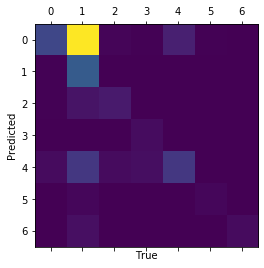

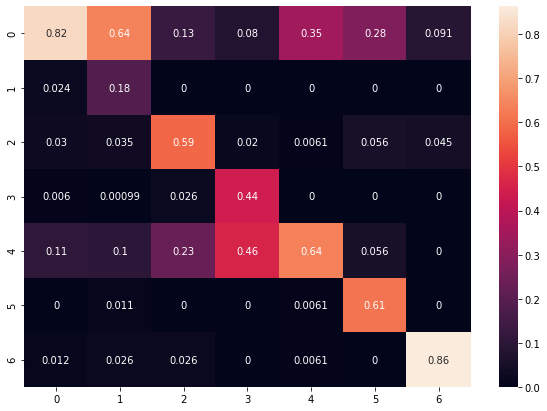

In [34]:
# add an evaluation module for the dataset
# this takes each image in the datset, does 4 flips of the image, and outputs the single prediction and 4 prediction -generates a confusion matrix
model = Net()
model.to(device)
checkpoint = "balanced_epoch3.pt"
if checkpoint:
    model,_,_,losses,accs = load_model(checkpoint,model, optimizer)
model.eval()

results,norm_results = evaluate(model,val_dataset)
plt.matshow(results)
plt.xlabel("True")
plt.ylabel("Predicted")

import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(norm_results, annot=True)



In [33]:
losses

{'train': [8.70169022679329,
  8.294225960969925,
  8.591077782213688,
  9.095029283314943,
  8.863635614514351,
  8.640049256384373,
  7.893349297344685,
  9.104505557566881,
  8.447694841772318,
  7.742495469748974,
  7.622938636690378,
  7.683232482522726,
  6.688507687300444,
  7.0870824418962,
  7.0882430374622345,
  6.845444578677416,
  6.761104345321655],
 'val': [50.18847155570984,
  64.42786797881126,
  42.35657888650894,
  49.53879015147686,
  46.39993007481098,
  50.093467980623245,
  48.066954240202904,
  57.76573972404003,
  55.712139427661896,
  50.4170198738575,
  49.16269539296627,
  52.19426289200783,
  51.234764233231544,
  56.240393221378326,
  54.474690064787865,
  50.984374940395355]}

In [0]:
sum([results[i,i] for i in range(0,7)])/np.sum(results)